In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Read data in and cut to region
#ds_moc = xr.open_dataset("../CESM_data/CESM1LE_MOC_NAtl_20N-50N_19200101_20051201.nc")

ds_sst = xr.open_dataset("../../CESM_data/CESM1LE_sst_NAtl_19200101_20051201.nc")['sst'][21:54,:,:,:]
#ds_FLNS = xr.open_dataset("../CESM_data/CESM1LE_FLNS_NAtl_19200101_20051201.nc")['FLNS'][21:54,0:89,:,:]
#ds_FSNS = xr.open_dataset("../CESM_data/CESM1LE_FSNS_NAtl_19200101_20051201.nc")['FSNS'][21:54,0:89,:,:]
#ds_LHFLX = xr.open_dataset("../CESM_data/CESM1LE_LHFLX_NAtl_19200101_20051201.nc")['LHFLX'][21:54,0:89,:,:]
#ds_NHFLX = xr.open_dataset("../CESM_data/CESM1LE_NHFLX_NAtl_19200101_20051201.nc")['NHFLX'][21:54,0:89,:,:]
#ds_SHFLX = xr.open_dataset("../CESM_data/CESM1LE_SHFLX_NAtl_19200101_20051201.nc")['SHFLX'][21:54,0:89,:,:]
ds_sss = xr.open_dataset("../../CESM_data/CESM1LE_sss_NAtl_19200101_20051201.nc")['sss'][21:54,0:89,:,:]
ds_psl = xr.open_dataset("../../CESM_data/CESM1LE_psl_NAtl_19200101_20051201.nc")['psl'][21:54,0:89,:,:]

In [4]:
# Apply Latitude Weights (Cosine of Latitude)
lat_weighted_sst = np.cos(ds_sst.lat*np.pi/180) * ds_sst
lat_weighted_sss = np.cos(ds_sss.lat*np.pi/180) * ds_sss
lat_weighted_psl = np.cos(ds_psl.lat*np.pi/180) * ds_psl

In [5]:
xr.open_dataset("../../CESM_data/CESM1LE_psl_NAtl_19200101_20051201.nc")['psl']

<xarray.DataArray 'psl' (lat: 96, lon: 105, time: 1032, ensemble: 42)>
[436907520 values with dtype=float32]
Coordinates:
  * lat       (lat) float64 0.4712 1.414 2.356 3.298 ... 87.17 88.12 89.06 90.0
  * lon       (lon) float64 -90.0 -88.75 -87.5 -86.25 ... 36.25 37.5 38.75 40.0
  * time      (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 34 35 36 37 38 39 40 41 42

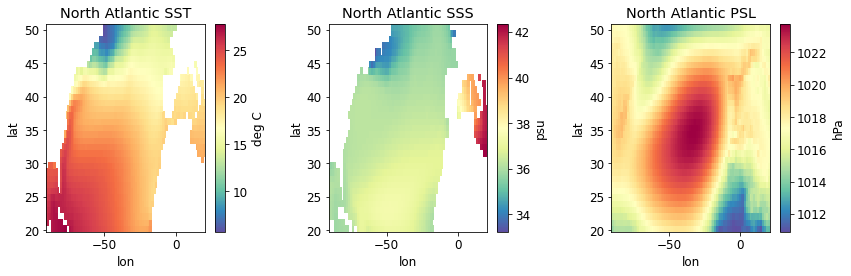

In [35]:
plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size': 12})

plt.subplot(131)
(ds_sst.mean(dim=('time','ensemble'))-273.15).plot(cmap='Spectral_r',cbar_kwargs={'label': 'deg C'})
plt.title('North Atlantic SST')

plt.subplot(132)
(ds_sss.mean(dim=('time','ensemble'))).plot(cmap='Spectral_r',cbar_kwargs={'label': 'psu'})
plt.title('North Atlantic SSS')

plt.subplot(133)
(ds_psl.mean(dim=('time','ensemble'))/100).plot(cmap='Spectral_r',cbar_kwargs={'label': 'hPa'})
plt.title('North Atlantic PSL')

plt.tight_layout()

plt.savefig('../Figures/SST_SSS_PSL_climatology.jpg', dpi=300)
plt.show()

In [36]:
def deseason(ds):
    data = ds.T.values
    monthly_means = np.zeros((42,86,12,89,33))
    
    iyr = 0
    for it in range(1032):
        mo_ind = it%12
        monthly_means[:,iyr,mo_ind,:,:] = data[:,it,:,:]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=1)
    
    data_deseason = np.zeros(data.shape)
    for it in range(1032):
        mo_ind = it%12
        data_deseason[:,it,:,:] = data[:,it,:,:] - monthly_means[:,mo_ind,:,:]

    data_deseason[np.isnan(data_deseason)] = 0
    return data_deseason

In [15]:
def deseason_detrend(ds):
    data = ds.T.values
    monthly_means = np.zeros((42,86,12,89,33))
    
    iyr = 0
    for it in range(1032):
        mo_ind = it%12
        monthly_means[:,iyr,mo_ind,:,:] = data[:,it,:,:]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=1)
    
    data_deseason = np.zeros(data.shape)
    for it in range(1032):
        mo_ind = it%12
        data_deseason[:,it,:,:] = data[:,it,:,:] - monthly_means[:,mo_ind,:,:]
    
    data_detrend = data_deseason - np.nanmean( data_deseason, axis=0 )
    data_detrend[np.isnan(data_detrend)] = 0
    return data_detrend



In [16]:
#%%time
sst_deseasoned = deseason(lat_weighted_sst)
sss_deseasoned = deseason(lat_weighted_sss)
psl_deseasoned = deseason(lat_weighted_psl)

<ipython-input-36-7d8a38611413>:11: RuntimeWarning: Mean of empty slice
  monthly_means = np.nanmean(monthly_means,axis=1)


CPU times: user 12.5 s, sys: 2.73 s, total: 15.2 s
Wall time: 15.3 s


In [17]:
#%%time6
sst_normed = (sst_deseasoned - np.mean(sst_deseasoned))/np.std(sst_deseasoned)
sss_normed = (sss_deseasoned - np.mean(sss_deseasoned))/np.std(sss_deseasoned)
psl_normed = (psl_deseasoned - np.mean(psl_deseasoned))/np.std(psl_deseasoned)

In [39]:
plt.figure(figsize=(12,3))
plt.rcParams.update({'font.size': 12})

plt.plot(np.mean(sst_normed,axis=(0,2,3)))
plt.plot(np.mean(sss_normed,axis=(0,2,3)))
plt.plot(np.mean(psl_normed,axis=(0,2,3)))
plt.legend(['sst','sss','psl'])

NameError: name 'sst_normed' is not defined

<Figure size 864x216 with 0 Axes>

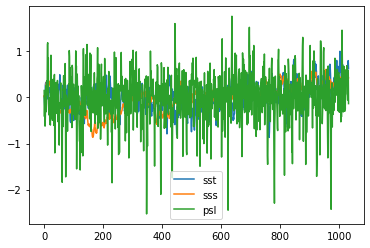

In [19]:
plt.plot(np.mean(sst_normed,axis=(2,3))[30,:])
plt.plot(np.mean(sss_normed,axis=(2,3))[30,:])
plt.plot(np.mean(psl_normed,axis=(2,3))[30,:])
plt.legend(['sst','sss','psl'])

In [20]:
sst_normed.shape

(42, 1032, 89, 33)

In [21]:
np.save("../CESM_data/CESM_SST_normalized_lat_weighted.npy",sst_normed)

In [22]:
np.save("../CESM_data/CESM_SSS_normalized_lat_weighted.npy",sss_normed)

In [23]:
np.save("../CESM_data/CESM_PSL_normalized_lat_weighted.npy",psl_normed)

In [16]:
.08*.29

0.0232/0.5

0.0464

In [15]:
np.nanmax(sst_deseasoned)

4.136080444760694